## Introducción
En este notebook de Jupyter se resumen algunas funciones útiles para el análisis y preprocesamiento de datos, incluyendo funciones de discretización, normalización y estandarización de variables, entre otros. Estas funciones están diseñadas para facilitar la exploración de los datos, tanto para atributos como para datasets y han sido creadas para la signatura de Software Matemático y Estadístico del máster Ingeniería Computacional y Sistemas Inteligentes de la UPV/EHU.

Primero, se cargarán los paquetes necesarios:

In [488]:
import pandas as pd
import numpy as np

## Funciones de discretización
### Función para discretizar variables
La siguiente función sirve para discretizar una variable. Para ello, se pueden utilizar tres métodos: el método *igual anchura*, el método *igual frecuencia* o directamente con los puntos de corte que se quieran utilizar. Para seleccionar el método, hay que utilizar el parámetro **method**:

- **method = 1:** La función utilizará el método *igual anchura*
- **method = 2:** La función utilizará el método *igual frecuencia* 

El método por defecto de la función es el método igual anchura. Si se le pasa los números de corte a la función (**cut_points**), se ignorará el tipo de método que se haya seleccionado y se utilizarán los puntos de corte elegidos.

Para los métodos *igual anchura* e *igual frecuencia*, será necesario pasarle a la función el número de intervalos que se quiere. Para ello se utilizará el parámetro **num_bins**.

Esta función devuelve una lista con dos elementos:

- **variable:** Es la variable discretizada. Se devuelve una matriz y los valores son una I y el numero de intervalo al que pertenece. Por ejemplo, "I3". Eso significaría que ese valor pertenece al intervalo número 3.
- **cortes:**  Es la lista de puntos de corte, que se devuelven para poder ser usado posteriormente para discretizar mas valores

Si se utiliza el método *igual frecuencia* pero no se utiliza un número de intervalos multiplo a la cantidad de elementos en la variable, aparecerá un aviso. En los intervalos no habrá la misma cantidad de elementos, los primeros intervalos tendrán un elemento más.

En todos los casos, los puntos de corte devueltos nos indican los números que forman los límites de los intervalos. El número del límite inferior no entra dentro del intervalo. Por ejemplo, los límites del segundo intervalo serían el valor de la segunda fila (este no incluido) y el valor de la tercera fila (este incluido) del vector o matriz de puntos de corte.

In [489]:
# Función para discretizar una variable
def discretize_v(x, num_bins=None, method=1, cut_points=None):

    # Se crea un atributo formato array con una columna y tantas filas como sea necesarias
    atributo = np.array(x).reshape(-1, 1)

    # Se crea un array vacío con las dimensiones de "atributo" para guardad los resultados
    atributo_discretizado = np.full(atributo.shape, '', dtype=object)

    # Si no se le entrega a la función los puntos de corte:
    if cut_points is None:

        # Se crea un array de zeros para guardar los valores de los puntos de corte
        cortes = np.zeros((num_bins + 1, 1))

        # Si el método es igual anchura:
        if method == 1:

            # Se calcula el tamaño del intervalo (la cantidad de elementos que irán en cada intervalo)
            valor_min = np.min(atributo)
            valor_max = np.max(atributo)
            valor_intervalo = (valor_max - valor_min) / num_bins

            # Se calculan y guardan los puntos de corte 
            for i in range(1, num_bins + 1):
                cortes[i] = valor_min + i * valor_intervalo

            # Se agrega el valor -infinito y el valor infinito al principio y final del array de cortes
            cortes[0] = -np.inf
            cortes[num_bins] = np.inf

            for i in range(num_bins):
                for n in range(atributo.shape[0]):
                    if cortes[i] < atributo[n] <= cortes[i + 1]:
                        atributo_discretizado[n] = f"I{i + 1}"
                        
        # Si el método es igual a frecuencia:
        elif method == 2:

            # Se calcula el valor entero y el valor del residuo entre la cantidad de elementos en la variable y la cantidad de intervalos
            valor_entero = atributo.shape[0] // num_bins
            valor_residuo = atributo.shape[0] % num_bins

            # Se ordenan los elementos de la variable
            valores_ordenados = np.argsort(atributo, axis=0)
            cont = 0

            # Se crea un array de 1s para guardar la secuencia de puntos de cortes que se van a utilizar para dividir los datos
            seq = np.zeros(num_bins + 1, dtype=int)

            for i in range(1, num_bins + 1):

                # Se le dan valores a la secuencia: El primer valor será el índice 1 (el valor más pequeño)
                # Se le irá sumando el valor entero de la división, que será la cantidad de elementos que habrá en cara intervalo
                # Se consiguen los índices que definen los intervalos
                seq[i] = seq[i - 1] + valor_entero

            # Si la cantidad de elementos no es múltiplo a la cantidad de intervalos
            if valor_residuo != 0:

                # Si la cantidad de intervalso y la cantidad de elementos en la variable no son múltiplos, se imprimirá una advertencia. 
                # Los primeros "valor_residuo" intervalos tendrán un elemento más que el resto
                print("¡Cuidado! El número de elementos en la variable no es múltiplo de la cantidad de intervalos")
                for res in range(1, valor_residuo + 1):
                    seq[res + 1:] += 1
            
            for i in range(num_bins):
                cont += 1

                # Se calculan los índices de los elementos para cada intervalo
                indices = valores_ordenados[seq[i]:seq[i + 1]]

                # A los valores con esos índices se les asigna ese intervalo
                atributo_discretizado[indices] = f"I{cont}"
                
                # Se guarda el valor máximo del intervalo como un punto de corte
                max_valor = np.max(atributo[indices])
                cortes[cont] = max_valor

            # Se agrega -infinito e infinito al principio y final
            cortes[num_bins] = np.inf
            cortes[0] = -np.inf

    # Si se la da a la función los puntos de corte, se ignorará el método seleccionado y se utilizarán estos puntos 
    else:
        cut_points = np.array(cut_points).reshape(-1, 1)
        
        # Se crea un array de 0s para guardar los valores de los cortes en un formato más adecuado
        cortes = np.zeros((cut_points.shape[0] + 2, 1))
        
        # Se añade -infinito e infinito al principio y al final
        cortes[0] = -np.inf
        cortes[-1] = np.inf

        # Se agregan los puntos de corte al nuevo array "cortes"
        for c in range(cut_points.shape[0]):
            cortes[c + 1] = cut_points[c]

        # Con los puntos de corte, se asignan valores a cada intervalo
        for i in range(1, cortes.shape[0]):
            for n in range(atributo.shape[0]):
                if cortes[i - 1] < atributo[n] <= cortes[i]:
                    atributo_discretizado[n] = f"I{i}"

    return {"variable": atributo_discretizado, "cortes": cortes}


Ejemplo de discretización de una variable usando el método de *igual anchura* con 3 intervalos:

In [24]:
variable = np.random.choice(range(1, 11), 10, replace=False)
resultado = discretize_v(variable, num_bins=3, method=1)

print("\nDataset discretizado:")
print(resultado["variable"])
print("\nCortes:")
print(resultado["cortes"])


Dataset discretizado:
[['I1']
 ['I1']
 ['I3']
 ['I2']
 ['I2']
 ['I3']
 ['I3']
 ['I1']
 ['I1']
 ['I2']]

Cortes:
[[-inf]
 [  4.]
 [  7.]
 [ inf]]


Ejemplo de discretización de una variable usando el método de igual frecuencia con 4 intervalo:

In [25]:
results = discretize_v(variable, num_bins = 4, method = 2)

print("\nDataset discretizado:")
print(results["variable"])
print("\nCortes:")
print(results["cortes"])

¡Cuidado! El número de elementos en la variable no es múltiplo de la cantidad de intervalos

Dataset discretizado:
[['I1']
 ['I2']
 ['I4']
 ['I3']
 ['I3']
 ['I4']
 ['I3']
 ['I1']
 ['I2']
 ['I2']]

Cortes:
[[-inf]
 [  2.]
 [  5.]
 [  8.]
 [ inf]]


Sale el aviso porque el número de intervalos no es múltiplo al número de elementos. 

## Función para discretizar datasets
Para discretizar un dataset se utilza la función implementada para discretizar una variable. En este caso se obtiene la matriz discretizada por columnas y los puntos de corte utilizados en cada columna. Los puntos de corte se interpretan de la misma forma que en el caso anterior.

In [27]:
# Función para discretizar un dataset completo
def discretize_dataset(x, num_bins=None, method=1, cut_points=None):
    dataset = np.array(x)
    
    # Se crea una matriz de 0s para guardar los valores del dataset discretizados
    dataset_discretizado = np.zeros(dataset.shape, dtype=object)
    
    # Se crea una matiz de zeros para guardar los valores de los cortes
    cortes = np.zeros((num_bins + 1, dataset.shape[1]))

    # La discretización se hace por columnas
    for l in range(dataset.shape[1]):

        # Se consigue la variable (columna) actual
        atributo = dataset[:, l].reshape(-1, 1)

        # Se consiguen la variable discretizada y sus puntos de corte
        resultado = discretize_v(atributo, num_bins=num_bins, method=method, cut_points=cut_points)

        # Se guarda la variable discretizada y sus puntos de corte
        dataset_discretizado[:, l] = resultado["variable"].flatten()
        cortes[:, l] = resultado["cortes"].flatten()

    return {"dataset_discretizado": dataset_discretizado, "cortes": cortes}

Discretización usando el método de igual anchura con 3 intervalos:

In [28]:
dataset = np.random.randint(1, 11, size=(10, 3))
result = discretize_dataset(dataset, num_bins=3, method=1)

print("Dataset Discretizado:")
print(result["dataset_discretizado"])
print("\nCortes:")
print(result["cortes"])

Dataset Discretizado:
[['I2' 'I3' 'I1']
 ['I3' 'I2' 'I2']
 ['I2' 'I1' 'I1']
 ['I2' 'I2' 'I2']
 ['I2' 'I1' 'I2']
 ['I2' 'I2' 'I3']
 ['I1' 'I1' 'I2']
 ['I3' 'I1' 'I3']
 ['I2' 'I2' 'I2']
 ['I1' 'I1' 'I1']]

Cortes:
[[      -inf       -inf       -inf]
 [3.66666667 4.         4.        ]
 [6.33333333 7.         7.        ]
 [       inf        inf        inf]]


Discretización usando el método de igual frecuencia con 5 intervalos:

In [29]:
results=discretize_dataset(dataset, num_bins = 5, method = 2)

print("Dataset Discretizado:")
print(results["dataset_discretizado"])
print("\nCortes:")
print(results["cortes"])

Dataset Discretizado:
[['I2' 'I5' 'I1']
 ['I5' 'I4' 'I2']
 ['I4' 'I1' 'I2']
 ['I3' 'I4' 'I3']
 ['I2' 'I3' 'I3']
 ['I4' 'I5' 'I5']
 ['I1' 'I2' 'I4']
 ['I5' 'I1' 'I5']
 ['I3' 'I3' 'I4']
 ['I1' 'I2' 'I1']]

Cortes:
[[-inf -inf -inf]
 [  3.   2.   2.]
 [  4.   3.   5.]
 [  5.   5.   5.]
 [  6.   7.   6.]
 [ inf  inf  inf]]


## Función para calcular métricas para los atributos de un dataset

Esta función calcula las métricas para los atributos de un dataset. Esta función reconoce el tipo de atributo y, actuando en base a eso, calcula la varianza y AUC para las variables contínuas y la entropía para las discretas. En el caso del AUC, el dataset debe ser supervisado, por lo que es necesario especificar una variable clase binaria con la que evaluar el AUC de los atributos numéricos (en formato booleano). El parámetro que recogerá esa clase binaria es **clase_bin**. Esta función tiene como parámetro de entrada, aparte de la clase binaria para el AUC, el dataset del que se quieren calcular las métricas y devuleve una lista con los resultados de cada métrica:

- **varianza:** Devuelve la varianza y el número de columna del dataset al que pertenece esa métrica. Para acceder al valor de la varianza hay que utilizar *"value"*, y para acceder al número de columna, *"col"*.
- **auc:** Devuelve el AUC y, al igual que en el caso de la varianza, el número de columna del dataset. En el caso del AUC, se devuelve el ratio de falsos positivos (FPR) y verdaderos positivos(TPR).
- **entropy** Devuelve la entropía y, al igual que en los otros dos casos, el número de columna al que pertenece. 

In [404]:
# Definir la función de métrica principal
def metrics(dataset, clase_bin):
    v, a, e = [], [], []
    colv, cole, cola = [], [], []

    # Se calculan las métricas por columnas
    for j in range(len(dataset[0])):
        atributo = dataset[:, j]

        # Se calcula la varianza y el AUC para variables contínuas
        # No se puede utilizar type() porque las matrices no guardan la diferencia entre variables continuas y discretas
        # Se mira si el valor real menos el valor entero dan diferente a cero (float)
        if (atributo-atributo.astype(int)).any()!=0:

            # Se calcula la varianza con una función implementada más adelante
            v.append(varianzas_function(atributo))

            # Se guarda el número de columna al que pertenece la varianza
            colv.append(j)

            # Se crea una matriz de ceros
            data_auc = np.zeros((len(atributo), 2))

            # Se añade los valores de la variable en la primera columna
            data_auc[:, 0] = atributo

            # Se añaden los valores de la clase binaria en la segudna columna
            data_auc[:, 1] = clase_bin

            # Se calcula el AUC con una función implementada más adelante
            a.append(auc_function(data_auc)["AUC"])

            # Se guardan el número de las columnas al que pertenece el valor AUC
            cola.append(j)

        # Se calcula la entropía para variables discretas 
        else:

            # Se calcula la entrpía con una función implementada más adelante
            e.append(entropy_function(atributo))

            # Se guarda el número de columna
            cole.append(j)

    # Se gaurdan los valores en un diccionario
    entropy = {"value": e, "col": cole}
    auc = {"value": a, "col": cola}
    varianza = {"value": v, "col": colv}

    return {"varianza": varianza, "auc": auc, "entropy": entropy}


# Función para calcular varianza
def varianzas_function(atributo):

    # Se calcula la varianza de la mariable
    media = np.mean(atributo)
    sum_square = np.sum((atributo - media) ** 2)
    varianza = sum_square / (len(atributo) - 1)
    return varianza


# Función para calcular entropía
def entropy_function(x):

    # Se guardan los valores únicos de x y cuantas veces aparecen
    valores, counts = np.unique(x, return_counts=True)

    # Se calcula la probabilidad (el porcentaje) de cuantas veces aparece ese valor
    probabilidades = counts / len(x)
    entropia = 0

    for p in probabilidades:
        # Se calcula la entropía
        entropia = entropia-np.sum([p * (np.log2(p))])
    return entropia


# Función para calcular el AUC
def auc_function(dataset):

    # Se ordena el dataset en orden descendente
    dataset_ordenada = dataset[dataset[:, 0].argsort()[::-1]]

    # Calcular la cantidad de positivos (sumando la cantidad de TRUE) y la cantidad de negativos (FALSE)
    num_positivos = np.sum(dataset[:, 1] == True)
    num_negativos = np.sum(dataset[:, 1] == False)

    # Calcular la media: los elementos más grandes que la media se consideraran positivos y los demás negativos
    media = np.sum(dataset_ordenada[:,1])/dataset_ordenada.shape[0]
    
    TP, FP = 0, 0
    TPRs, FPRs = [], []

    # Se suman los verdaderos positivos y los falsos positivos
    for i in range(len(dataset_ordenada)):
        if dataset_ordenada[i, 0] >= media:
            if dataset_ordenada[i, 1] == True:
                TP += 1
            else:
                FP += 1

        # Se guardan los resultados en las listas
        TPRs.append(TP / num_positivos)
        FPRs.append(FP / num_negativos)

    # Se calcula el AUC usando el método del trapecio: base (intervalo de falsos positivos) * altura (media de los verdaderos positivos)
    AUC = 0
    for i in range(1, len(TPRs)):
        base = FPRs[i] - FPRs[i - 1]
        altura = (TPRs[i] + TPRs[i - 1]) / 2
        AUC += base * altura
        
    # Se devuelven los ratiso de TP y de FP y el valor de AUC
    return {"TPR": TPRs, "FPR": FPRs, "AUC": AUC}

Ejemplo de uso para la función metrics:

In [490]:
df = pd.DataFrame({
    "continua1": [1.5, 2.3, 3.1, 4.6, 5.8],
    "continua2": [10.2, 15.6, 20.1, 25.5, 30.0],
    "discreta1": [1, 2, 3, 4, 5]
})

clase = np.array([True, True, False, True, False])

# Convertir el DataFrame a numpy para poder pasarlo a la función
dataset = df.to_numpy()

result = metrics(dataset, clase_bin=clase)

print("Varianza:", result["varianza"])
print("AUC:", result["auc"])
print("Entropía:", result["entropy"])

Varianza: {'value': [3.0229999999999997, 61.31700000000001], 'col': [0, 1]}
AUC: {'value': [0.16666666666666666, 0.16666666666666666], 'col': [0, 1]}
Entropía: {'value': [2.321928094887362], 'col': [2]}


## Normalización y estandarización de variables y datasets
### Normalización de una variable
Esta función utiliza el método max-min para normalizar una variable. El parámetro de entrada es la variable que se quiere normalizar (**variable**) y la función devuelve esa variable normalizada, con valores entre 0 y 1 en formato matriz. 

In [491]:
# Función para normalizar una variable
def normalizar_variable(variable):

    # Aplicar la normalización a las variables numéricas (int y float)
    if type(variable[0])==np.float64 or type(variable)==np.int32:

        # Normalizarla con el método max-min: se elimina el valor mínimo a la variable y se le divide la resta entre el máximo y el mínimo
        variable_normalizada = (variable - np.min(variable)) / (np.max(variable) - np.min(variable))
        return variable_normalizada

    else:
        print("La variable no es numérica")
        return variable

In [492]:
variable = np.array([1.5, 2.3, 3.1, 4.6, 5.8])
variable_normalizada = normalizar_variable(variable)
print("Variable Normalizada:\n")
print(variable_normalizada)

Variable Normalizada:

[0.         0.18604651 0.37209302 0.72093023 1.        ]


La siguiente función utiliza la función implementada para normalizar una variable para normalizar un dataset completo. Para ello, se le entrega a la función el dataset que se quiere normalizar en formato dataframe o matriz. La normalización se realiza por columnas.

In [493]:
# Función para normalizar un dataset
def normalizar_dataset(dataset):

    # Se hace una copia del dataset para guardar los valores normalizados
    dataset_normalizado = dataset.copy()

    # Se normaliza el dataset por columnas
    for col in dataset.columns:
        
        # Se utiliza la función implementada anteriormente para normalizar la variable actual 
        dataset_normalizado[col] = normalizar_variable(dataset[col])
        
    return dataset_normalizado

In [494]:
df = pd.DataFrame({
    "V1": [1.5, 2.3, 3.1, 4.6, 5.8],
    "V2": [10.2, 15.6, 20.1, 25.5, 30.0],
    "V3": [1.1, 2.2, 1.3, 1.4, 0.95]
})

df_normalizado = normalizar_dataset(df)
print("Dataset Normalizado:\n")
print(df_normalizado)

Dataset Normalizado:

         V1        V2    V3
0  0.000000  0.000000  0.12
1  0.186047  0.272727  1.00
2  0.372093  0.500000  0.28
3  0.720930  0.772727  0.36
4  1.000000  1.000000  0.00


### Estandarización de un dataset
Esta función sirve para estandarizar un dataset completo. Para ello, en este caso también se utiliza la función utilizada para estandarizar una única variable. Esta función también coge la matriz a estandarizar y la devuelve en formato mariz.

In [303]:
# Función para estandarizar una variable
def estandarizar_variable(variable):

    # Solo se aplica la estandarización a valores numéricos
    if type(variable[0])==np.float64 or type(variable)==np.int32:

        # Se calcula la media
        media = np.sum(variable) / len(variable)
        
        suma_cuadrados = 0

        # Se calcula la desviación estandar
        for valor in variable:
            suma_cuadrados += ((valor-media) ** 2)
            
        desv = (suma_cuadrados / (len(variable) - 1))** 0.5

        # Se estandariza la variable eliminandole la media y dividiéndolo por la desviación estandar
        variable_estandarizada = (variable - media) / desv

        # Convertir a formato de matriz (columna)
        return variable_estandarizada

    else:
        print("La variable no es numérica")
        return variable

In [307]:
variable = np.array([1.5, 2.3, 3.1, 4.6, 5.8])
variable_estandarizada = estandarizar_variable(variable)
print("Variable Estandarizada:\n")
print(variable_estandarizada)

Variable Estandarizada:

[-1.12729349 -0.6671737  -0.20705391  0.6556707   1.34585039]


In [308]:
# Función para estandarizar un dataset completo
def estandarizar_dataset(dataset):
    
    # Hacer una copia del dataset original
    dataset_estandarizado = dataset.copy()  

    # Se estandariza por columnas
    for col in dataset.columns:

        # Se estandariza la variable utilizando la función implementada anteriormente
        dataset_estandarizado[col] = estandarizar_variable(dataset[col])
        
    return dataset_estandarizado

In [311]:
df = pd.DataFrame({
    "V1": [1.5, 2.3, 3.1, 4.6, 5.8],
    "V2": [10.2, 15.6, 20.1, 25.5, 30.0],
    "V3": [1.1, 2.2, 1.3, 1.4, 0.95]
})

df_estandarizado = estandarizar_dataset(df)

print("Dataset Estandarizado:\n")
print(df_estandarizado)

Dataset Estandarizado:

         V1        V2        V3
0 -1.127293 -1.287271 -0.597589
1 -0.667174 -0.597662  1.669128
2 -0.207054 -0.022987 -0.185459
3  0.655671  0.666623  0.020607
4  1.345850  1.241297 -0.906687


## Filtrado de variables en base a las métricas entropía, AUC y varianza
Esta función filtra un dataset en base a una métrica y una condición seleccionadas. Para ello, la función recibe los siguienes parámetros de entrada: 
- **dataset:** El dataset que se quiere filtrar.
- **clase_bin:** Para calcular el AUC es necesario especificar una variable clase binaria con la que evaluar el AUC, por lo que este parámetro recoge esa clase binaria en formato booleano.
- **metric:** La métrica que se quiera utilizar para filtrar el dataset. Hay tres opciones: la entropía (metric = "entropia"), la varianza (metric = "varianza") y AUC (metric = "AUC").
- **condition:** La condición que se quiera que las variables cumplan. Por ejemplo, "=0.5" o "<4". La condición tiene que ser formato caracter y primero tiene que ir la operación matemática y después el valor. Si se quiere filtrar en base a un intervalo de valores, se aplicará dos veces esta función. Un ejemplo de esto sería filtrar el dataset y quedarse solo con las variables que tengan una entropía mayor que 2 y menor que 5. Para ello, primero se aplicará la función *dataset_filt <- filtrar_dataset(dataset, metric = "entropia", condition = ">2")* y después, *filtrar_dataset(dataset_filt, metric = "entropia", condition = "<=5")*. 

El valor por defecto en el parámetro **metric** es "entropía" y la **condition** por defecto es ">1". 

Está función solo devolverá las variables que cumplan la condición. Si se elige la métrica entropía, solo se devolverán las variables que cumplan la condición establecida y que sean discretas. En el caso de elegir la varianza o el AUC, solo se devolverán las variables que sean contínuas y que cumplan la condición. Si no hay variables que cumplan la condición o no hay variables del tipo que cada métrica exige, se devolverá una matriz vacía.


In [314]:
# Función para filtrar un dataset en base a una métrica y una condición
def filtrar_dataset(dataset, clase_bin=None, metric="entropia", condition=">1"):
    
    # Obtenemos el operador y el valor de la condición
    operator = condition[0]
    value = float(condition[1:])

    # Calculalmos las métricas con la función implementada anteriormente
    results = metrics(dataset, clase_bin)

    # Creamos una lista vacía para guardar las columnas que cumplan la condición
    columnas = []

    # Si la métrica elegida es la entropía:
    if metric == "entropia":

        # Conseguimos los valores de las entropías y las columnas a las que pertenecen
        entropias = results['entropy']['value']
        col = results['entropy']['col']
        
        count = 0

        # Por cada entropía calculada, se ve si cumple la condición y se guardan las columnas de las que sí
        for e in entropias:
            if operator == ">" and e > value:
                columnas.append(col[count])
            elif operator == "<" and e < value:
                columnas.append(col[count])
            elif operator == ">=" and e >= value:
                columnas.append(col[count])
            elif operator == "<=" and e <= value:
                columnas.append(col[count])
            elif operator == "==" and e == value:
                columnas.append(col[count])
            count += 1

    # Si la métrica elegida es el AUC:
    elif metric == "AUC":

        # Conseguimos los valores del AUC y las columnas a las que pertenecen
        AUC = results['auc']['value']
        col = results['auc']['col']

        count = 0

        # Por cada AUC calculado, se ve si cumple la condición establecida y se guardan las columnas de las que sí
        for a in AUC:
            if operator == ">" and a > value:
                columnas.append(col[count])
            elif operator == "<" and a < value:
                columnas.append(col[count])
            elif operator == ">=" and a >= value:
                columnas.append(col[count])
            elif operator == "<=" and a <= value:
                columnas.append(col[count])
            elif operator == "==" and a == value:
                columnas.append(col[count])
            
            count +=1

    # Si la métrica elegida es la varianza:
    elif metric == "varianza":

        # Conseguimos los valores de las varianzas y los números de las columnas
        varianza = results['varianza']['value']
        col = results['varianza']['col']

        count = 0

        # por cada varianza calculada, se mira si cumplen la condición y se guardan las columnas de las que sí
        for v in varianza:
            if operator == ">" and v > value:
                columnas.append(col[count])
            elif operator == "<" and v < value:
                columnas.append(col[count])
            elif operator == ">=" and v >= value:
                columnas.append(col[count])
            elif operator == "<=" and v <= value:
                columnas.append(col[count])
            elif operator == "==" and v == value:
                columnas.append(col[count])
            count += 1
    
    # Se guardan los datos que cumplan las condiciones
    dataset_filtrado = dataset[columnas]
    return dataset_filtrado

In [322]:
# Crear el DataFrame
df = pd.DataFrame({
    "V1": [1.5, 2.3, 3.1, 4.6, 5.8],
    "V2": [10.2, 15.6, 20.1, 25.5, 30.0],
    "V3": [1, 2, 3, 4, 5]
})

# Convertir el DataFrame a numpy para poder pasarlo a la función
dataset = df.to_numpy()

# Clase binaria
clase = [True, True, False, True, False]

# Filtrar el dataset
filtered_dataset = filtrar_dataset(dataset, clase_bin=clase, metric="varianza", condition="<4")

print("Dataset Filtrado:\n")
print(filtered_dataset)

Dataset Filtrado:

[[ 1.5 10.2  1. ]]


## Cálculo de la correlación
Esta función calcula la correlación (información mutua en el caso de variables categóricas) por pares entre las variables de un dataset. La función considera de que tipo es cada variable y actúa en base a ello.

Para ello, la función recoge como parámetro de entrada el dataset del que se quiera calcular la matriz de correlación o información mútua. Devuelve una matriz con esos resultados. El dataset de entrada debe de ser formato numpy.

In [472]:
# Función para calcular la correlación o información mútua
def correlacion_mutua(dataset):
    n = dataset.shape[1]

    # Se crea una matriz de zeros de n x n para guardar las correlaciones entre las variables del dataset
    correlacion_matriz = np.zeros((n, n))

    for i in range(n):
        for j in range(n):

            # Calcular correlación de Pearson para variables continuas
            if (dataset[0,i]-dataset[0,i].astype(int))!=0:
                if (dataset[0,j]-dataset[0,j].astype(int))!=0:

                    # Se utiliza la función implementada más adelante para calcular la correlación
                    correlacion_matriz[i, j] = calcular_pearson(dataset[:, i], dataset[:, j])

            # Calcular información mutua para variables categóricas (valores enteros)
            elif (dataset[0,i]-dataset[0,i].astype(int))==0:
                if (dataset[0,j]-dataset[0,j].astype(int))==0:

                    # Se calcula la informmación mútua utilizando una función implementada más adelante
                    correlacion_matriz[i, j] = informacion_mutua(dataset[:, i], dataset[:, j])

            # Rellenar todos los valores que faltan teniendo en cuenta que la matriz es simétrica
            #correlacion_matriz[j, i] = correlacion_matriz[i, j]
             
    return correlacion_matriz

# Función para calcular la información mútua
def informacion_mutua(x, y):
    n = len(x)

    # Se buscan los elementos únicos de x e y
    valores_x = np.unique(x)
    valores_y = np.unique(y)
    info_mutua = 0

    # Calcular las frecuencias conjuntas y marginales
    for vx in valores_x:
        for vy in valores_y:
            p_xy = np.sum((x == vx) & (y == vy)) / n
            p_x = np.sum(x == vx) / n
            p_y = np.sum(y == vy) / n

            # Se calcula la información mutua
            # Se agrega una pequeña suma para evitar división por cero y log(0)
            info_mutua += p_xy * np.log2(p_xy + 1e-30 / (p_x * p_y + 1e-30))

    return info_mutua

def calcular_pearson(x, y):
    n = len(x)
    media_x = np.mean(x)
    media_y = np.mean(y)
    covarianza = np.sum((x - media_x) * (y - media_y))
    desviacion_x = np.sqrt(np.sum((x - media_x) ** 2))
    desviacion_y = np.sqrt(np.sum((y - media_y) ** 2))

    correlacion = covarianza / (desviacion_x * desviacion_y)
    return correlacion

In [474]:
# Ejemplo de uso
df = pd.DataFrame({
    'V1': np.random.normal(size=100),
    'V2': np.random.normal(size=100),
    'V3': pd.Categorical(np.random.choice([1, 2, 3], size=100)),
    'V4': pd.Categorical(np.random.choice([1, 2, 3, 4], size=100))
})

# Convertir el DataFrame a numpy para poder pasarlo a la función
dataset = df.to_numpy()

correlacion_resultados = correlacion_mutua(dataset)

print("Matriz de Correlación Mutua:\n")
print(correlacion_resultados)

Matriz de Correlación Mutua:

[[ 1.          0.0586114   0.          0.        ]
 [ 0.0586114   1.          0.          0.        ]
 [ 0.          0.         -1.57505001 -3.54966009]
 [ 0.          0.         -3.54966009 -1.9854753 ]]


## Plots para el AUC y para las matrices de correlación/información mutua
En este apartado se muestran dos funciones de visualización: la primera para visualizar la curva ROC y la segunda para visualizar la matriz de correlación/ información mútua de una variable. Para ambos casos se necesita importar matplotlib.pyplot:

In [ ]:
# Se instala el paquete para hacer plots
import matplotlib.pyplot as plt

### Plot para el AUC
Esta función plotea la curva ROC. Para ello se utilza la función para calcular el AUC implementada en el apartado de métricas. Se le debe pasar a la función la variable del que se quiere visualizar la curva y la variable clase binaria con la que evaluar el AUC, en formato booleano.

In [353]:
def plot_auc(atributo, class_bin):

    # Nos aseguramos de que sean arrays
    atributo = np.array(atributo)
    class_bin = np.array(class_bin)

    # Creamos una matriz de 0s para guardar los datos para la función auc_function()
    data_auc = np.zeros((len(atributo), 2))
    
    # Agregamos el atributo en la primera columna y la clase binaria en la segunda columna
    data_auc[:, 0] = atributo
    data_auc[:, 1] = clase_bin

    # Calculamos el AUC y los TPRs Y FPRs
    resultados = auc_function(data_auc)
    AUC = resultados["AUC"]
    TPR = resultados["TPR"]
    FPR = resultados["FPR"]

    # Se plotea la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(FPR, TPR, color='blue', label='Curva ROC (AUC = {:.2f})'.format(AUC))
    plt.title('Curva ROC')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

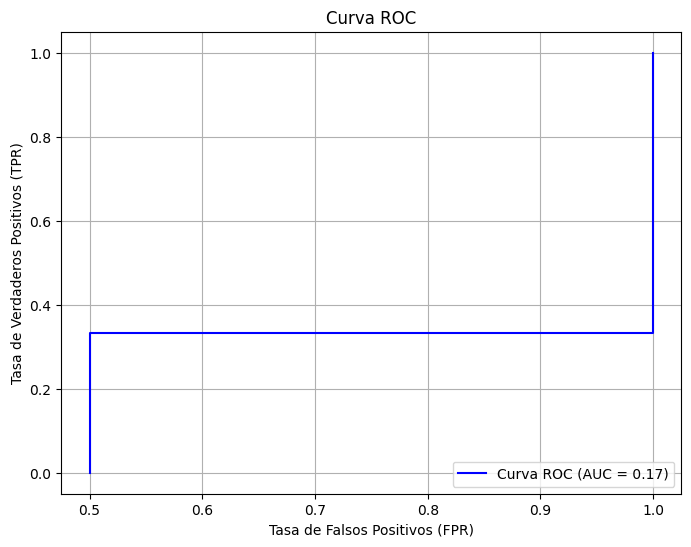

In [356]:
atributo = np.array([1.5, 2.3, 3.1, 4.6, 5.8])
clase = np.array([True, True, False, True, False])

plot_auc(atributo, clase_bin)

### Plot para las matrices de correlación/información mutua
Esta función plotea la correlación/información mútua entre los elementos de una variable. Para ello se utilza la función implementada en uno de los apartados anteriores, el que se utiliza para calcular la correlación/información mútua. Esta función crea una especie de mapa de calor, donde las variables representadas de forma más roja son las más correlacionadas. También se muestra la correlación de forma numérica. 

Se le debe pasar a la función la variable del que se quiere visualizar el mapa de correlación/información mútua.

In [487]:
# Función para plotear la correlación/información mútua
def plot_info_mutua(dataset):

    # Calculamos la matriz de correlación/información mútua con la función implementada antes
    correlation_matrix = correlacion_mutua(dataset)

    # Crear un mapa de calor
    # Se crea la figura (tamaño 10 x 8) y los ejes del plot
    fig, ejes = plt.subplots(figsize=(10, 8))
    
    # Crear una máscara de los valores iguales a 0, para que las casillas sean blancas (para los valores que no sea han calculado)
    mask = correlation_matrix == 0
    
    # Mostrar el mapa de calor con la máscara aplicada
    heatmap = ejes.matshow(np.ma.masked_where(mask, correlation_matrix), cmap='coolwarm')
    plt.colorbar(heatmap)
    
    # Se ponen los ticks (marcas) de los ejes x e y
    ejes.set_xticks(np.arange(len(df.columns)))
    ejes.set_yticks(np.arange(len(df.columns)))

    # Se ponen las etiquetas (los nombres de las columnas) a las marcas
    ejes.set_xticklabels(df.columns)
    ejes.set_yticklabels(df.columns)

    # Usar tres bucles for para iterar sobre la matriz
    for i in range(correlation_matrix.shape[0]):          
        for j in range(correlation_matrix.shape[1]): 
            
            # Se obtiene el valor en la posición (i, j)
            val = correlation_matrix[i, j]
            if val != 0:    
                # Mostrar los valores en cada celda (centradas en el centro)
                ejes.text(j, i, f"{val:.2f}", ha='center', va='center')

    plt.title("Matriz de Correlación e Información Mutua")
    plt.show()

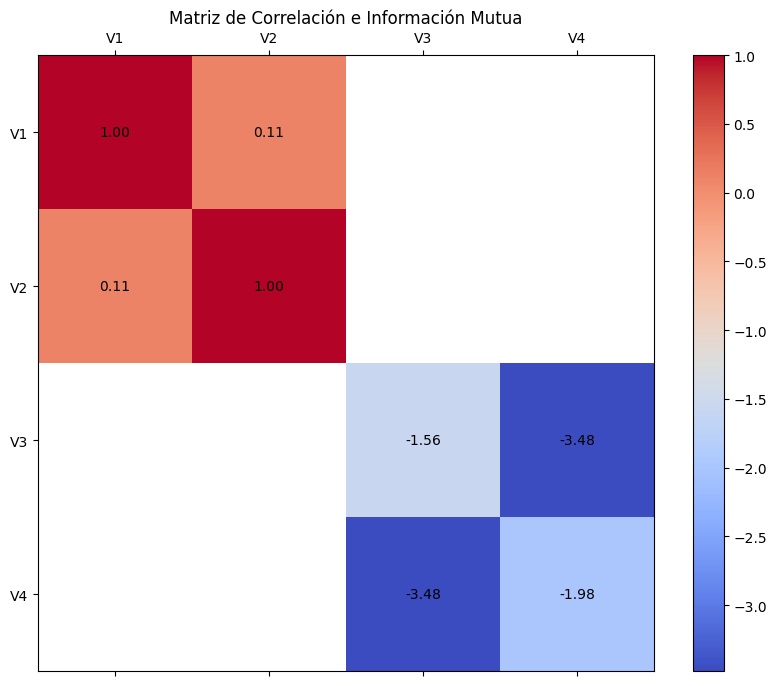

In [485]:
np.random.seed(0)
df = pd.DataFrame({
    'V1': np.random.randn(100),
    'V2': np.random.randn(100),
    'V3': pd.Categorical(np.random.choice([1, 2, 3], size=100)),
    'V4': pd.Categorical(np.random.choice([1, 2, 3, 4], size=100))
})

# Convertir el DataFrame a numpy para poder pasarlo a la función
dataset = df.to_numpy()

plot_info_mutua(dataset)